In [1]:
dfs = {}
preprocessed = {}

In [2]:
import rdata

converted = rdata.read_rda("E:\projects\microagg1d\datasets\Tarragona.rda")
converted["Tarragona"]
dfs["Tarragona"] = converted["Tarragona"].drop_duplicates()
preprocessed["Tarragona"] = converted["Tarragona"].drop_duplicates()

In [3]:
converted = rdata.read_rda("E:\projects\microagg1d\datasets\EIA.rda")
converted["EIA"]
dfs["EIA"] = converted["EIA"].drop_duplicates()
preprocessed["EIA"]=dfs["EIA"][['RESREVENUE', 'RESSALES', 'COMREVENUE', 'COMSALES', 'INDREVENUE', 'INDSALES', 'OTHREVENUE', 'OTHRSALES', 'TOTREVENUE', 'TOTSALES']].drop_duplicates()

In [4]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [5]:
from microagg1d import univariate_microaggregation
from microagg1d.common import compute_cluster_cost_sorted
from microagg1d.cost import compute_cost
from microagg1d.main import undo_argsort
import numpy as np

In [6]:
def square_sum(x):
    return np.sum(np.square(x))

def absolute_sum(x):
    return np.sum(np.abs(x))

def multi_cost(df_in, clusters, cost_name="sse", preprocess=True):
    df = do_preprocessing(df_in, preprocess)
    average = {
        "sse" : np.mean,
        "sae" : np.median,
    }[cost_name]
    cost_func = {
        "sse" : square_sum,
        "sae" : absolute_sum,
    }[cost_name]
    num_clusters = clusters.max() + 1
    total_cost=0
    for i in range(num_clusters):
        select = clusters == i
        df_select = df[select,:]
        centroid = average(df_select,axis=0)
        total_cost += cost_func(df_select-centroid)
    return total_cost

In [7]:
def do_preprocessing(df_in, preprocess):
    if preprocess:
        return preprocessing.StandardScaler().fit_transform(df_in)
    return df_in

In [8]:
def compute_multi_pca(df_in, k, cost_name="sse", preprocess=True):
    df = do_preprocessing(df_in, preprocess)
    pca = PCA(n_components=1)
    pca.fit(df)
    vec = pca.components_[0,:]
    arr = df @ vec
    order = np.argsort(arr)
    arr = np.array(arr[order], dtype=np.float64)
    clusters = univariate_microaggregation(arr, cost=cost_name, k=k)
    return undo_argsort(clusters, order), vec, order

In [9]:
def compute_multi_random(df_in, k, num_tries=10, cost_name="sse", seed=None, preprocess=True):
    df = do_preprocessing(df_in, preprocess)
    if seed is not None:
        np.random.seed(seed)
    best_clusters= None
    best_vec = None
    best_cost = np.inf
    for i in range(num_tries):
        vec = np.random.rand(df.shape[1])
        arr = df @ vec
        order = np.argsort(arr)
        arr = np.array(arr[order], dtype=np.float64)
        clusters = univariate_microaggregation(arr, cost=cost_name, k=k)
        clusters = undo_argsort(clusters, order)
        cost = multi_cost(df, clusters, cost_name=cost_name, preprocess=False)
        if cost < best_cost:
            best_clusters=clusters
            best_cost=cost
            best_arr = undo_argsort(arr, order)
            best_order = undo_argsort(order, order)
        
    return best_clusters, best_vec, best_order, best_cost

In [10]:
def k_means_heuristic(df_in, k, n_clusters, seed=None, preprocess=True):
    if seed is not None:
        np.random.seed(seed)
    df = do_preprocessing(df_in, preprocess)
    n_clusters = min(n_clusters, len(df))
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed).fit(df)
    all_labels = set(kmeans.labels_)
    labels = kmeans.labels_.copy()
    centroids = kmeans.cluster_centers_.copy()
    changes=False
    while True:
        group_sizes = np.bincount(labels, minlength=len(all_labels)+1)
        labels_to_iter = np.random.permutation(np.fromiter(all_labels, count=len(all_labels), dtype=np.int64))
        if np.all(group_sizes[labels_to_iter] >= k):
            break
        
        
        
        for group_label in labels_to_iter:
            group_size = group_sizes[group_label]
            if group_size < k:
                this_centroid = centroids[group_label]
                min_dist = np.inf
                best_neigh = None
                for i in all_labels:
                    centroid = centroids[i]
                    if i==group_label or group_sizes[i]==0:
                        continue
                    
                    distance = np.sum(np.square(centroid - this_centroid))
                    if distance < min_dist:
                        best_neigh = i
                        min_dist = distance
                centroids[best_neigh] = (centroids[best_neigh]*group_sizes[best_neigh] + 
                                         centroids[group_label]*group_sizes[group_label])/ (
                                        group_sizes[best_neigh] + group_sizes[group_label])
                
                labels[labels==group_label] = best_neigh
                group_sizes[best_neigh] += group_sizes[group_label]
                group_sizes[group_label] = 0
                all_labels.remove(group_label)
                # print("removing", group_label, "to", best_neigh)
                tmp = np.bincount(labels,minlength=len(group_sizes))
                if not np.all(group_sizes == tmp):
                    print(group_sizes)
                    print(tmp)
                    print(group_sizes-tmp)
                    raise ValueError()    
    final_labels = labels.copy()
    
    d = {l:i for i, l in enumerate(all_labels)}
    for i,l in enumerate(labels):
        final_labels[i] = d[l]
    return final_labels

In [11]:
from sklearn.cluster import KMeans

In [12]:
cost_name = "sse"

In [13]:
from collections import defaultdict
import pickle
from tqdm.notebook import tqdm

In [14]:
the_ks = [2,3,4,5,7,10,20,30,40,50]
num_repeats=10 # number of times a randomized experiment should be repeated
list_num_tries = [10, 50, 100]

In [15]:
results = {}

In [16]:
def string_to_datetime(s):
    l = []
    for item in s.split("_"):
        if len(item)>0:
            l.append(int(item))
    assert len(l)==6
    return datetime(*l)

In [76]:
load = True
if load:
    try:
        with open("results\._2024_10_14__12_20_15.pkl", "rb") as f:
            results = pickle.load(f) 
    except FileNotFoundError:
        print("Could not find file to load")

In [18]:
skip_present = True

### PCA based projection approach

In [19]:
if skip_present and "pca" in results:
    pass
else:
    results["pca"] = defaultdict(list)
    for name, df in preprocessed.items():
        df = preprocessing.StandardScaler().fit_transform(df)
        for k in the_ks:
            clusters, arr, order = compute_multi_pca(df, k=k, preprocess=False)
            cost = multi_cost(df, clusters, cost_name=cost_name)

            results["pca"][name].append((k, cost))

In [ ]:
import time
time.sleep(0.1)

In [114]:
def multi_cost_poly(df_in, result, cost_name="sse", preprocess=True):
    df = do_preprocessing(df_in, preprocess)
    average = {
        "sse" : np.mean,
        "sae" : np.median,
    }[cost_name]
    cost_func = {
        "sse" : square_sum,
        "sae" : absolute_sum,
    }[cost_name]
    
    # assign the steiner to a random cluster if used multiple times
    multiple_steiners = defaultdict(list)
    is_assigned = {}
    steiner_sets = []
    for i, (steiners, comp) in enumerate(result):
        steiner_sets.append(set(steiners))
        for s in steiners:
            multiple_steiners[s].append(i)
        for s in comp:
            is_assigned[s]=True
    for s, indices in multiple_steiners.items():
        if is_assigned[s]:
            continue
        r = np.random.randint(len(indices))
        i = indices[r]
        steiner_sets[assigned].remove(s)
    
    total_cost=0
    for steiners, (_, comp) in zip(steiner_sets, result):
        df_select = df[comp,:]
        centroid = average(df_select, axis=0)
        inds = list(set(comp)-set(steiners))
        assert len(inds)==1
        df_select2 = df[inds,:]
        total_cost += cost_func(df_select2-centroid)
    return total_cost

In [115]:
from microagg1d.multivariate_poly import get_partitions_multivariate_poly, set_both_seeds, apply_basic, decompose_components, compute_dists, get_k_closest

### Overlapping baseline

Below is a dummy algorithm for the overlapping case. This solves the task by finding for each row the k-1 closest other rows and creates the anonymized row by merging these k rows.

In [116]:
def simple_approx(df, k, dists=None):
    import pandas as pd
    if isinstance(df, pd.DataFrame):
        arr = df.to_numpy()
    else:
        arr = df
    # print(arr)
    if dists is None:
        dists = compute_dists(arr)
    # print(dists)
    closest_neighbors = get_k_closest(dists, k-1)
    out = []
    for i, val in enumerate(closest_neighbors):
        out.append((list(val), np.array([i]+list(val), dtype=np.int64)))
    return out

In [117]:
set_both_seeds(0)


label = f"simple_neigh"
results[label] = defaultdict(list)
for name, df in tqdm(preprocessed.items(), leave=False):
    df = preprocessing.StandardScaler().fit_transform(df)
    dists = compute_dists(df)
    for k in tqdm(the_ks, leave=False):
        costs = []
        for seed in tqdm(range(num_repeats), leave=False):
            set_both_seeds(seed)
            clusters = simple_approx(df, k, dists=dists)
            cost = multi_cost_poly(df, clusters, cost_name=cost_name, preprocess=True)
            costs.append(cost)
        results[label][name].append((k, np.mean(costs), np.std(costs)))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

### Polynomial time approximation algo

In [51]:
set_both_seeds(0)


for forbid_overlap in tqdm([True, False]):
    for make_additional_split in tqdm([True, False]):
        label = f"poly_{forbid_overlap}_{make_additional_split}"
        results[label] = defaultdict(list)
        for name, df in tqdm(preprocessed.items(), leave=False):
            df = preprocessing.StandardScaler().fit_transform(df)
            dists = compute_dists(df)
            for k in tqdm(the_ks, leave=False):
                costs = []
                for seed in tqdm(range(num_repeats), leave=False):
                    set_both_seeds(seed)
                    clusters = get_partitions_multivariate_poly(df, k, forbid_overlap, dists=dists, make_additional_split=make_additional_split)
                    if forbid_overlap:
                        cost = multi_cost(df, clusters, cost_name=cost_name, preprocess=True)
                    else:
                        #clusters = additional_split(clusters, df, k)
                        cost = multi_cost_poly(df, clusters, cost_name=cost_name, preprocess=True)
                    costs.append(cost)
                results[label][name].append((k, np.mean(costs), np.std(costs)))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

### Random projection

In [52]:
if skip_present and all(f"random_{num_tries}" in results for num_tries in list_num_tries):
    pass
else:
    np.random.seed(0)
    for num_tries in tqdm(list_num_tries):
        label = f"random_{num_tries}"
        results[label] = defaultdict(list)
        for name, df in preprocessed.items():
            df = preprocessing.StandardScaler().fit_transform(df)
            for k in tqdm(the_ks, leave=False):
                costs = []
                for seed in tqdm(range(num_repeats), leave=False):
                    clusters, arr, order, cost = compute_multi_random(df, k=k, num_tries=num_tries, cost_name=cost_name, preprocess=False)
                    costs.append(cost)
                results[label][name].append((k, np.mean(costs), np.std(costs)))

### Kmeans plus post processing

In [53]:
list_factors = [0.5,1,2]
if skip_present and all(f"merged_{factor}" in results for factor in list_factors):
    pass
else:
    np.random.seed(0)

    for factor in tqdm(list_factors, leave=False):
        label = f"merged_{factor}"
        results[label] = defaultdict(list)
        for name, df in preprocessed.items():
            df = preprocessing.StandardScaler().fit_transform(df)
            for k in tqdm(the_ks, leave=False):
                costs = []
                for seed in tqdm(range(num_repeats), leave=False):
                    clusters = k_means_heuristic(df, k=k, n_clusters=int(len(df)/k*factor))
                    cost = multi_cost(df, clusters, cost_name=cost_name, preprocess=True)
                    costs.append(cost)
                results[label][name].append((k, np.mean(costs), np.std(costs)))

# Plotting

In [55]:
import matplotlib.pyplot as plt

In [56]:
import matplotlib
from pathlib import Path

In [57]:
rc_fonts = {
    "font.family": "serif",
    "font.size": 12,
    'figure.figsize': (5, 3),
    "text.usetex": True,
    'text.latex.preamble': 
        r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
}
matplotlib.rcParams.update(rc_fonts)

In [134]:
def plot_external_legend(original_ax, identifier, figsize=(15.5, 0.5), fontsize=16):
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fig, legend_ax = plt.subplots(1, 1,figsize=figsize, sharey=True)
        #fig.set_facecolor("black")
        #fig.pad_inches(0)
        fig.set_tight_layout(True)
        #legend_ax.set_facecolor("black")
        #legend_ax.set_ymargin(-0.1)
        handles, labels = original_ax.get_legend_handles_labels()
        #labels, handles = zip(*sorted(zip(labels, handles)))
        legend_ax.axis('off')
        print(legend_ax.margins())
        #legend_ax.margins(y=0)
        fig.legend(handles, labels, loc='center', mode="expand", ncol=10,  fontsize=fontsize)
        #legend_ax.set_autoscale(enable=True, tight=True)
        fig.savefig(Path(".")/Path('figures')/f'legend_{fontsize}_{identifier}.pdf')

In [135]:
for dataset in results["poly_True_True"]:
    arr1 = np.array(results["poly_True_True"][dataset])[:,1]
    arr1_std = np.array(results["poly_True_True"][dataset])[:,2]
    arr2 = np.array(results["poly_False_True"][dataset])[:,1]
    arr2_std = np.array(results["poly_True_True"][dataset])[:,2]
    
    print(dataset)
    print("rel error", np.max(np.abs(arr1-arr2)/((arr1+arr2)/2)))
    print("rel std", np.max(np.abs(arr1_std/arr1)), np.max(np.abs(arr2_std/arr2)))

Tarragona
rel error 0.04757699074679984
rel std 0.11334845304259518 0.11608684581260569
EIA
rel error 0.05555188078100382
rel std 0.12537682144472265 0.12533169591187096


(0.05, 0.05)


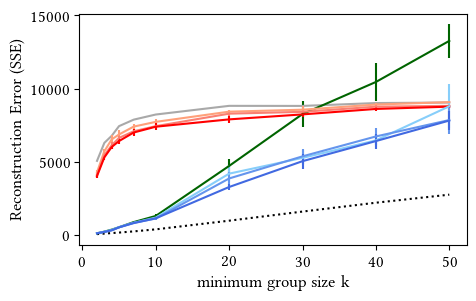

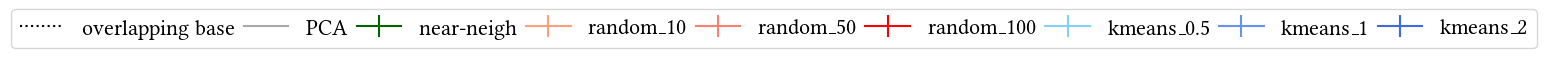

(0.05, 0.05)


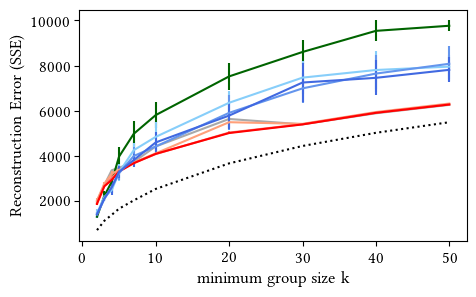

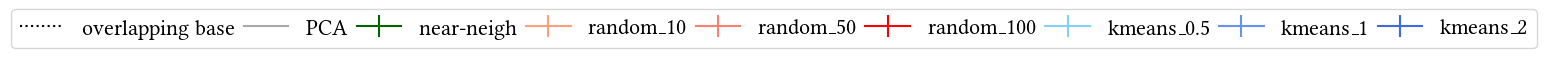

In [139]:
for dataset in ["EIA", "Tarragona"]:
    fig = plt.figure(figsize=(5,3))
    for label, method, color in zip(
        ["overlapping base", "near-neigh", "PCA", "random_10", "random_50", "random_100", "kmeans_0.5", "kmeans_1", "kmeans_2"],
        ["simple_neigh","poly_True_True", "pca", "random_10", "random_50", "random_100", "merged_0.5", "merged_1", "merged_2"], 
        ["k","darkgreen",  "darkgray", "lightsalmon", "salmon", "red","lightskyblue", "cornflowerblue", "royalblue" ]):
        if method not in results:
            print("skipping", method)
            continue
        res = results[method][dataset]
        arr = np.array(res)
        ls = "-"
        if method=="simple_neigh":
            ls = ":"
        # print(arr, method, dataset)
        if arr.shape[1]==3 and method!="simple_neigh":
            x = arr[:,0]
            y = arr[:,1]
            yerr = arr[:,2]
            plt.errorbar(x, y, yerr=yerr, label=label, color=color, linestyle=ls)
        else:
            x = arr[:,0]
            y = arr[:,1]
            plt.plot(x,y, label=label, color=color, linestyle=ls)
    # plt.legend()
    plt.xlabel("minimum group size k")
    plt.ylabel("Reconstruction Error (SSE)")
    # plt.title(dataset)
    
    fig.savefig(Path(".")/'figures'/(dataset+".pdf"), bbox_inches = 'tight', transparent=True)
    # plt.show()
    plot_external_legend(plt.gca(), dataset)
    plt.show()

## Explanation of the plot

The dotted line ("overlapping base") demonstrates a very simple case where for each row we find the k-1 closests rows and merge them to obtain a k anonymous row for each row. It is thus a very very simplistic baseline and solves a different task compared to the task that the other methods are trying to solve. (The other methods allow each node to be part of only one cluster).
I would claim that no non-overlapping solution can be better than this overlapping solution, it may thus serve as a hard baseline of how much improvement is possible in the best case.

The nearest-neighbor based approach is supposedly optimal up to a factor of k (if it would work). There is some doubt that the method actually works. Either this method solves the overlapping task (where the overlapping baseline solves it better) or does not work correctly if it intends to solve the non-overlapping task. Surprisingly it works worse than the k-means based approaches throughout.

The k-means based approach solves the task by first doing a k-means clustering with many clusters and then merging clusters with the closest other clusters until all clusters are of large enough size.

The random projection and PCA bases approaches project the problem into 1D and solve the 1D task optimally, only to then project the solution back into higher dimensions.

In [137]:
from datetime import datetime
from pathlib import Path
import pickle
def save_results(prefix, data):
    now = datetime.now()
    
    date_suffix = now.strftime("%Y_%m_%d__%H_%M_%S")
    folder = Path("./results/")
    if not folder.exists():
        raise ValueError(f'Path "{folder.absolute()}" not found')
    out_name = folder/(f"{prefix}_"+date_suffix+".pkl")


    print(out_name)
    with open(out_name, "wb") as f:
        pickle.dump(data, f)

In [64]:
save_results(".", results)

results\._2024_10_14__12_20_15.pkl


In [ ]:
print(
    len(dfs["EIA"]),
    len(dfs["EIA"].columns))

In [ ]:
print(
    len(dfs["Tarragona"]),
    len(dfs["Tarragona"].columns))